# Optimize the Beale Function using `tf.train.Optimizer`

* This code is implemented by [`TensorFlow`](https://www.tensorflow.org) **NOT** `numpy` in order to compare the result of my optimizer which is made by only `numpy`.
* I've check that my codes are OK. ^o^
* This code whose name is `optimizer.tf.version.plot.ipynb` is implemented in order to compare all optimization pathes of various optimizers at a glance.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

import tensorflow as tf
tf.enable_eager_execution()

In [2]:
def f(x, y):
  return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [3]:
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)
print("minima (1x2 row vector shape): {}".format(minima))
print("minima (2x1 column vector shape):")
print(minima_)

minima (1x2 row vector shape): [3.  0.5]
minima (2x1 column vector shape):
[[3. ]
 [0.5]]


In [4]:
sgd = tf.train.GradientDescentOptimizer(0.01)
momentum = tf.train.MomentumOptimizer(0.005, momentum=0.9, use_nesterov=False)
nesterov = tf.train.MomentumOptimizer(0.005, momentum=0.9, use_nesterov=True)
adagrad = tf.train.AdagradOptimizer(0.05)
rmsprop = tf.train.RMSPropOptimizer(learning_rate=0.01, decay=0.9, epsilon=1e-10)
adam = tf.train.AdamOptimizer(learning_rate=0.05, beta1=0.9, beta2=0.999, epsilon=1e-8)

optimizers = [sgd, momentum, nesterov, adagrad, rmsprop, adam]
opt_names = ['sgd', 'momentum', 'nesterov', 'adagrad', 'rmsprop', 'adam']

In [5]:
all_pathes = []
for opt, name in zip(optimizers, opt_names):
  x_init = 0.8
  x = tf.get_variable('x', dtype=tf.float32, initializer=tf.constant(x_init))
  y_init = 1.6
  y = tf.get_variable('y', dtype=tf.float32, initializer=tf.constant(y_init))

  #print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}".format(0, f(x, y).numpy(), x.numpy(), y.numpy()))
  x_history = []
  y_history = []
  z_prev = 0.0
  max_steps = 1000
  for step in range(max_steps):
    with tf.GradientTape() as g:
      #g.watch([x, y])
      z = f(x, y)
    x_history.append(x.numpy())
    y_history.append(y.numpy())
    dz_dx, dz_dy = g.gradient(z, [x, y])
    opt.apply_gradients(zip([dz_dx, dz_dy], [x, y]))

    #if (step+1) % 100 == 0:
    #  print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}  dx: {:.5f}  dy: {:.5f}".format(step+1, f(x, y).numpy(), x.numpy(), y.numpy(), dz_dx.numpy(), dz_dy.numpy()))
      
    if np.abs(z_prev - z.numpy()) < 1e-6:
      break
    z_prev = z.numpy()
  print("{} training done!".format(name))
  print("  steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}".format(step+1, f(x, y).numpy(), x.numpy(), y.numpy()))
      
  x_history = np.array(x_history)
  y_history = np.array(y_history)
  path = np.concatenate((np.expand_dims(x_history, 1), np.expand_dims(y_history, 1)), axis=1).T
  all_pathes.append(path)

sgd training done!
  steps: 839  z: 0.000153  x: 2.96963  y: 0.49232
momentum training done!
  steps: 298  z: 0.000027  x: 3.01301  y: 0.50323
nesterov training done!
  steps: 270  z: 0.000027  x: 3.01310  y: 0.50325
adagrad training done!
  steps: 1000  z: 1.285840  x: 1.68116  y: 0.15987
rmsprop training done!
  steps: 412  z: 0.001103  x: 2.95831  y: 0.49556
adam training done!
  steps: 810  z: 0.000081  x: 2.97781  y: 0.49439


In [6]:
# putting together our points to plot in a 3D plot
number_of_points = 50
margin = 4.5
x_min = 0. - margin
x_max = 0. + margin
y_min = 0. - margin
y_max = 0. + margin
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

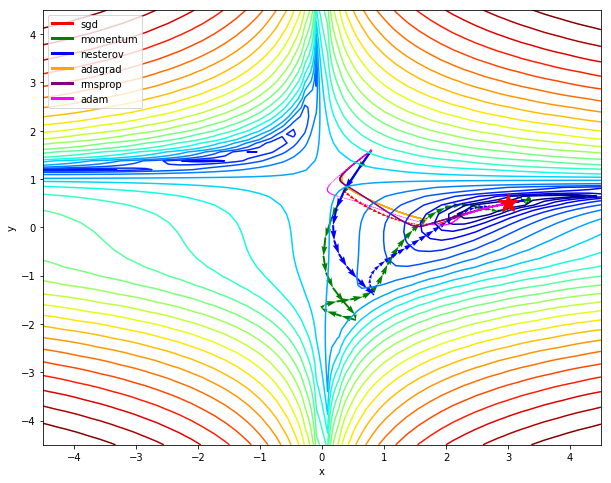

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-.5, 5, 25), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=20)
colors = ['red', 'green', 'blue', 'orange', 'purple', 'magenta']
for name, path, color in zip(opt_names, all_pathes, colors):
  ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
            scale_units='xy', angles='xy', scale=1, color=color, lw=3)
  ax.plot([], [], color=color, label=name, lw=3)

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

ax.legend(loc='upper left')

plt.savefig('allplot.pdf')
plt.show()